In [1]:
import yfinance as yf

import time

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as rmse, mean_absolute_percentage_error as mape

# 4

In [2]:
# ticker = "AMZN"

# data = yf.download(
#     ticker,
#     period="5y",
#     interval="1d",
#     auto_adjust=True,
#     threads=False
# )
# output_file = "AMZN_last_5_years.csv"

# print(data.head())


In [3]:
period = 45

In [4]:
df = pd.read_csv("AMZN_last_5_years.csv")

df = df[['Price', 'Close']].iloc[2:].reset_index(drop=True)

df = df.rename(columns={"Close": "price", "Price": "date"})

df["date"] = pd.to_datetime(df["date"])
df["price"] = pd.to_numeric(df["price"], errors="coerce")

In [5]:
df

,date,price
0,2020-12-10,155.074493
1,2020-12-11,155.820999
2,2020-12-14,157.848495
3,2020-12-15,158.255997
4,2020-12-16,162.048004
...,...,...
1250,2025-12-03,232.380005
1251,2025-12-04,229.110001
1252,2025-12-05,229.529999
1253,2025-12-08,226.889999


# 5

### 5.1.1

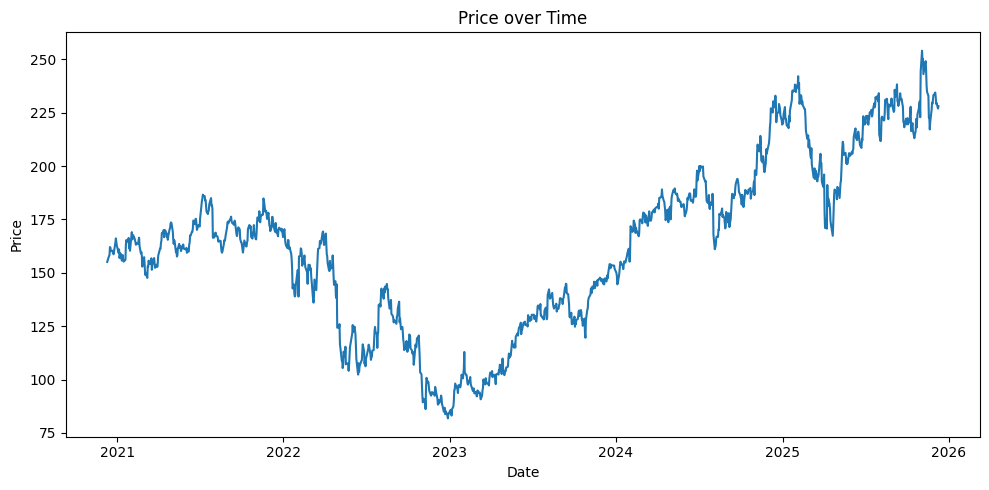

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["price"])
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Price over Time")
plt.tight_layout()

plt.show()

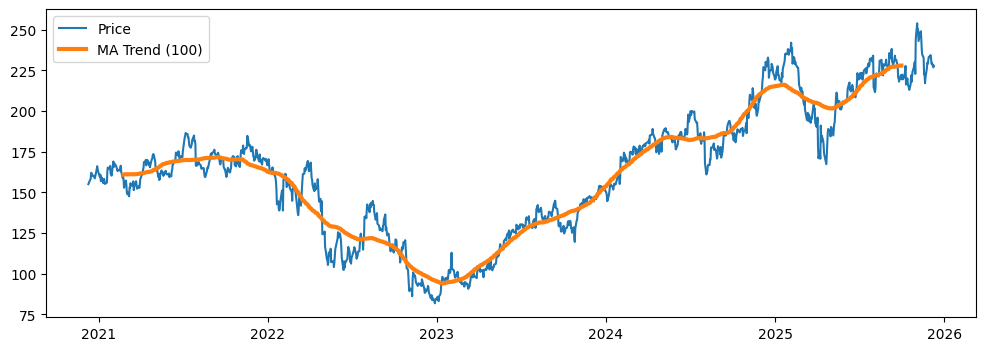

In [7]:
ts = df.set_index("date")["price"]
trend_ma = ts.rolling(window=100, center=True).mean()

plt.figure(figsize=(12,4))
plt.plot(ts, label="Price")
plt.plot(trend_ma, label="MA Trend (100)", linewidth=3)
plt.legend()
plt.show()


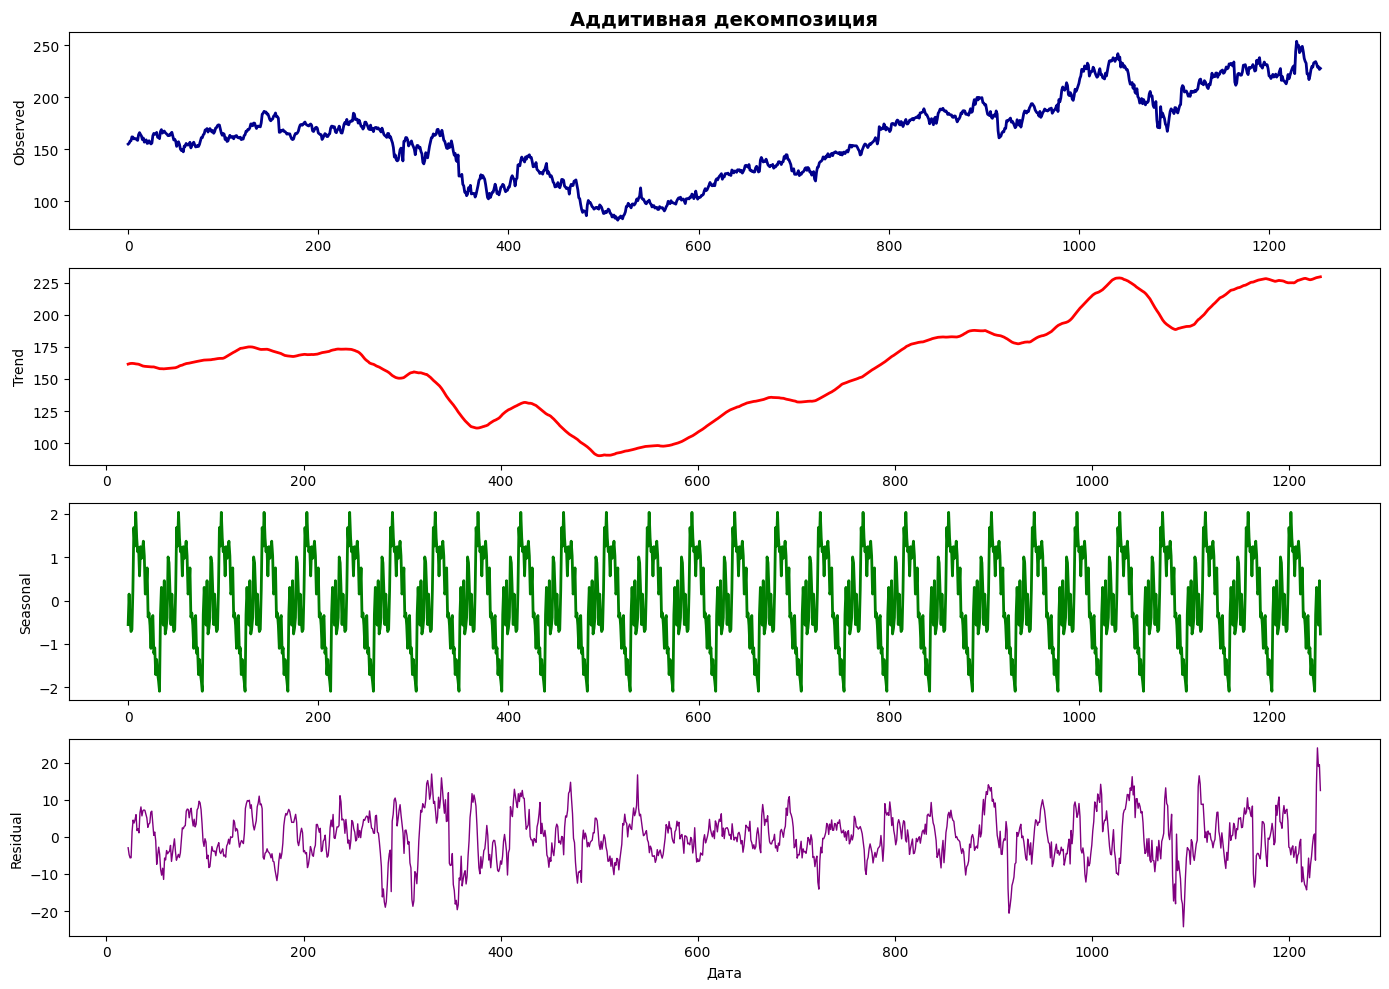

In [8]:
decomposition_add = seasonal_decompose(df['price'], model='additive', period=period)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

decomposition_add.observed.plot(ax=axes[0], color='darkblue', linewidth=2)
axes[0].set_ylabel('Observed')
axes[0].set_title('Аддитивная декомпозиция', fontsize=14, fontweight='bold')

decomposition_add.trend.plot(ax=axes[1], color='red', linewidth=2)
axes[1].set_ylabel('Trend')

decomposition_add.seasonal.plot(ax=axes[2], color='green', linewidth=2)
axes[2].set_ylabel('Seasonal')

decomposition_add.resid.plot(ax=axes[3], color='purple', linewidth=1)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Дата')

plt.tight_layout()
plt.show()

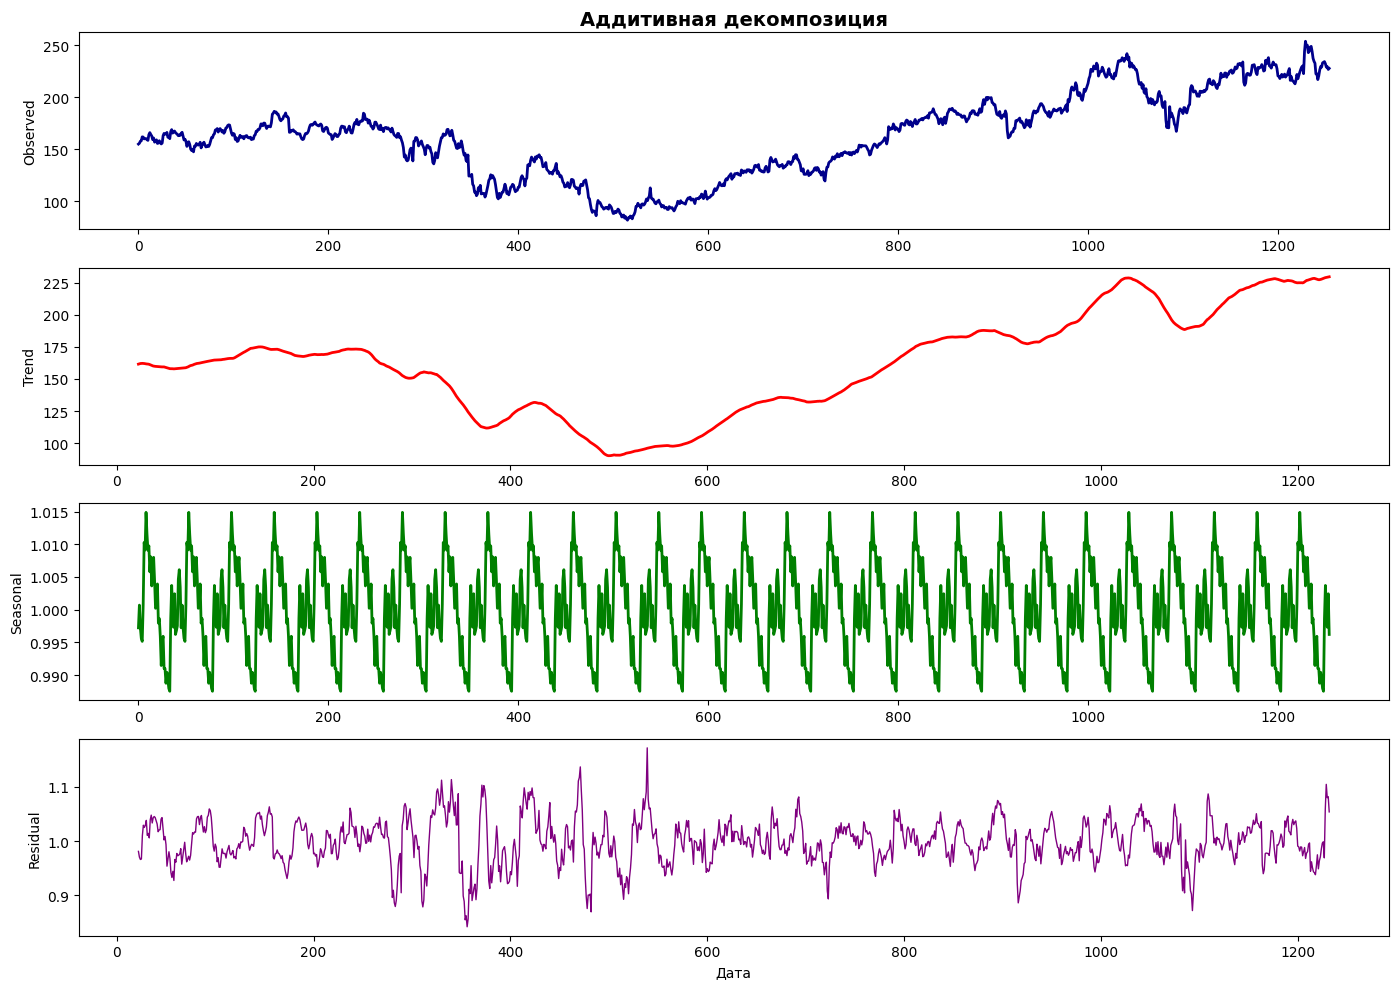

In [9]:
decomposition_add = seasonal_decompose(df['price'], model='multiplicative', period=period)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

decomposition_add.observed.plot(ax=axes[0], color='darkblue', linewidth=2)
axes[0].set_ylabel('Observed')
axes[0].set_title('Аддитивная декомпозиция', fontsize=14, fontweight='bold')

decomposition_add.trend.plot(ax=axes[1], color='red', linewidth=2)
axes[1].set_ylabel('Trend')

decomposition_add.seasonal.plot(ax=axes[2], color='green', linewidth=2)
axes[2].set_ylabel('Seasonal')

decomposition_add.resid.plot(ax=axes[3], color='purple', linewidth=1)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Дата')

plt.tight_layout()
plt.show()

тип процесса: AR(p)

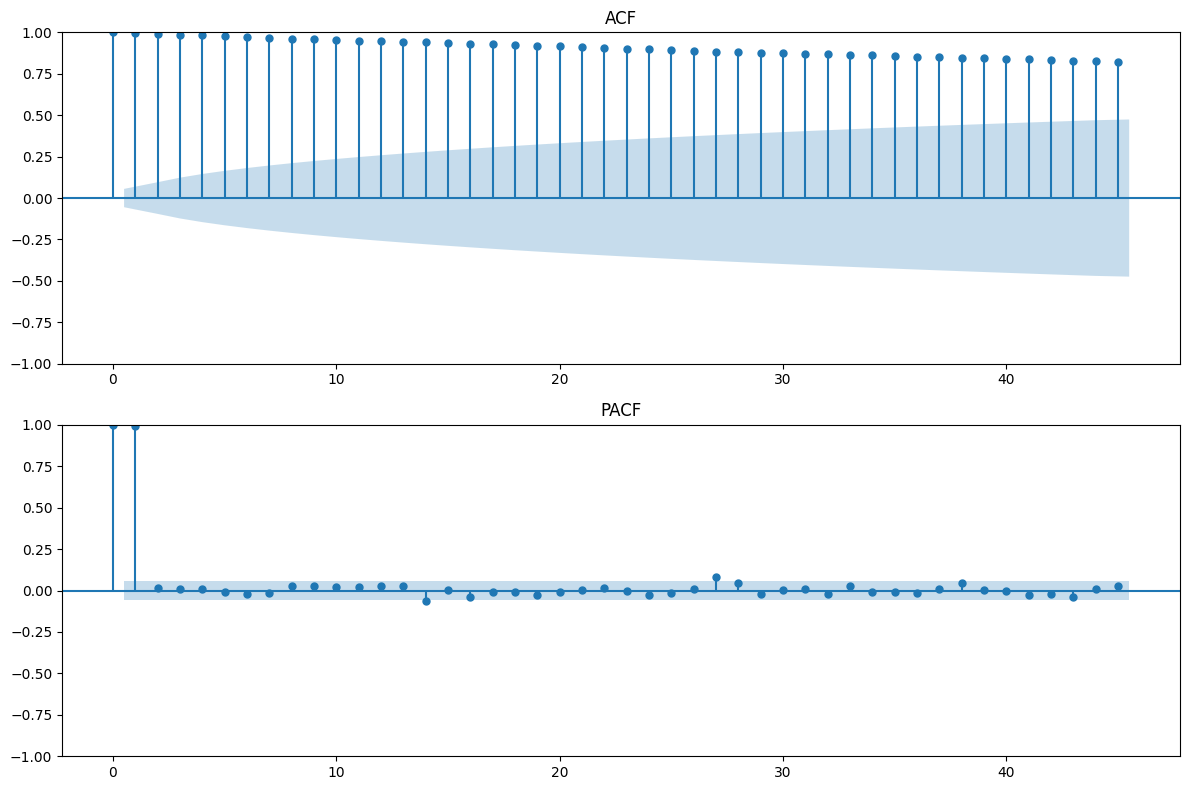

In [10]:
ts = df.set_index("date")["price"]

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(ts, ax=axes[0], lags=period)
axes[0].set_title("ACF")

plot_pacf(ts, ax=axes[1], lags=period, method='ywm')
axes[1].set_title("PACF")

plt.tight_layout()
plt.show()


### 5.1.2

In [11]:
ts = df.set_index("date")["price"].dropna()

# --- ADF Test ---
adf_result = adfuller(ts)

print("ADF Test:")
print(f"  Statistic: {adf_result[0]}")
print(f"  p-value:   {adf_result[1]}")
print("  Critical values:")
for k, v in adf_result[4].items():
    print(f"    {k}: {v}")

# --- KPSS Test ---
kpss_result = kpss(ts, regression='c', nlags='auto')

print("\nKPSS Test:")
print(f"  Statistic: {kpss_result[0]}")
print(f"  p-value:   {kpss_result[1]}")
print("  Critical values:")
for k, v in kpss_result[3].items():
    print(f"    {k}: {v}")

print()
if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
    print("СТАЦИОНАРЕН")
else:
    print("НЕСТАЦИОНАРЕН")

ADF Test:
  Statistic: -1.1013521976907337
  p-value:   0.7145323631967258
  Critical values:
    1%: -3.4355754676859886
    5%: -2.8638475772391665
    10%: -2.5679985805677017

KPSS Test:
  Statistic: 2.7930998347535474
  p-value:   0.01
  Critical values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739

НЕСТАЦИОНАРЕН


/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_42437/2440323435.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(ts, regression='c', nlags='auto')


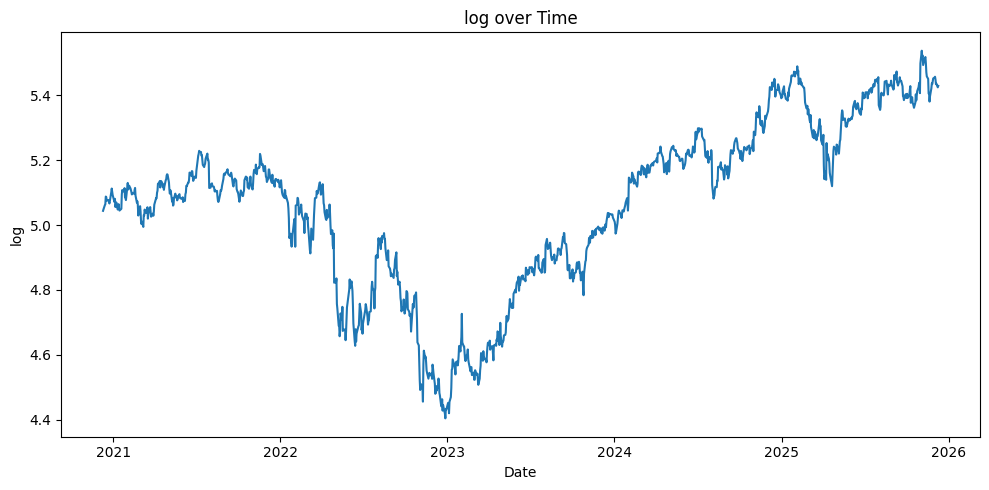

In [12]:
df['log'] = np.log(df['price'])

plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["log"])
plt.xlabel("Date")
plt.ylabel("log")
plt.title("log over Time")
plt.tight_layout()

plt.show()

In [13]:
ts = df.set_index("date")["log"].dropna()

# --- ADF Test ---
adf_result = adfuller(ts)

print("ADF Test:")
print(f"  Statistic: {adf_result[0]}")
print(f"  p-value:   {adf_result[1]}")
print("  Critical values:")
for k, v in adf_result[4].items():
    print(f"    {k}: {v}")

# --- KPSS Test ---
kpss_result = kpss(ts, regression='c', nlags='auto')

print("\nKPSS Test:")
print(f"  Statistic: {kpss_result[0]}")
print(f"  p-value:   {kpss_result[1]}")
print("  Critical values:")
for k, v in kpss_result[3].items():
    print(f"    {k}: {v}")

print()
if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
    print("СТАЦИОНАРЕН")
else:
    print("НЕСТАЦИОНАРЕН")

ADF Test:
  Statistic: -1.1772397943539132
  p-value:   0.6833091582147831
  Critical values:
    1%: -3.4355754676859886
    5%: -2.8638475772391665
    10%: -2.5679985805677017

KPSS Test:
  Statistic: 2.426175197348076
  p-value:   0.01
  Critical values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739

НЕСТАЦИОНАРЕН


/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_42437/1457289317.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(ts, regression='c', nlags='auto')


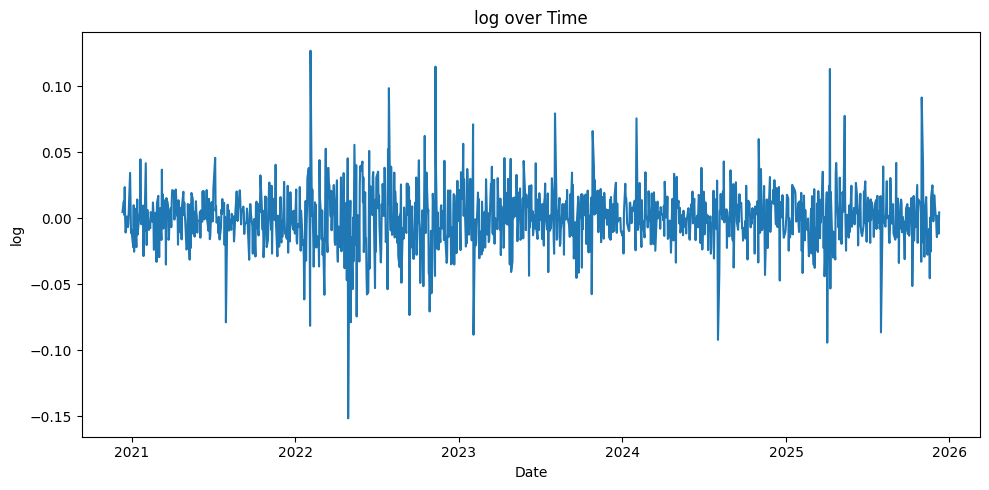

In [14]:
df['diff1'] = df['log'].diff()

plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["diff1"])
plt.xlabel("Date")
plt.ylabel("log")
plt.title("log over Time")
plt.tight_layout()

plt.show()

In [15]:
ts = df.set_index("date")["diff1"].dropna()

# --- ADF Test ---
adf_result = adfuller(ts)

print("ADF Test:")
print(f"  Statistic: {adf_result[0]}")
print(f"  p-value:   {adf_result[1]}")
print("  Critical values:")
for k, v in adf_result[4].items():
    print(f"    {k}: {v}")

# --- KPSS Test ---
kpss_result = kpss(ts, regression='c', nlags='auto')

print("\nKPSS Test:")
print(f"  Statistic: {kpss_result[0]}")
print(f"  p-value:   {kpss_result[1]}")
print("  Critical values:")
for k, v in kpss_result[3].items():
    print(f"    {k}: {v}")

print()
if adf_result[1] < 0.05 and kpss_result[1] > 0.05:
    print("СТАЦИОНАРЕН")
else:
    print("НЕСТАЦИОНАРЕН")

ADF Test:
  Statistic: -35.80232642162413
  p-value:   0.0
  Critical values:
    1%: -3.4355796466416777
    5%: -2.863849421064024
    10%: -2.5679995625056926

KPSS Test:
  Statistic: 0.13556298088964758
  p-value:   0.1
  Critical values:
    10%: 0.347
    5%: 0.463
    2.5%: 0.574
    1%: 0.739

СТАЦИОНАРЕН


/var/folders/d3/gkk0_sdx779g33ctfnpn540m0000gn/T/ipykernel_42437/1604112558.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(ts, regression='c', nlags='auto')


In [16]:
df = df.dropna(subset=["diff1"])

n = len(ts)
split = int(n * 0.8)
train = df[:split].copy()
test  = df[split:].copy()

h = len(test)

In [17]:
train

,date,price,log,diff1
1,2020-12-11,155.820999,5.048708,0.004802
2,2020-12-14,157.848495,5.061636,0.012928
3,2020-12-15,158.255997,5.064214,0.002578
4,2020-12-16,162.048004,5.087893,0.023679
5,2020-12-17,161.804001,5.086386,-0.001507
...,...,...,...,...
999,2024-12-02,210.710007,5.350483,0.013474
1000,2024-12-03,213.440002,5.363356,0.012873
1001,2024-12-04,218.160004,5.385229,0.021873
1002,2024-12-05,220.550003,5.396124,0.010896


Naive Forecast

In [18]:
last_diff = train['price'].iloc[-1]
naive_forecast = pd.Series(last_diff, index=test.index)

SES

In [19]:
last_log = train['log'].iloc[-1]

In [20]:
model_ses_price = ExponentialSmoothing(train['price'], trend=None, seasonal=None)
fit_ses_price = model_ses_price.fit(optimized=True)
ses_pred = fit_ses_price.forecast(steps=h)
ses_pred.name = 'SES_price'

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
model_ses_diff = ExponentialSmoothing(train['diff1'], trend=None, seasonal=None)
fit_ses_diff = model_ses_diff.fit(optimized=True)
ses_diff_fc = fit_ses_diff.forecast(steps=h)
log_forecast_ses = last_log + ses_diff_fc.cumsum()
ses_pred_diff = np.exp(log_forecast_ses)
ses_pred_diff = pd.Series(ses_pred_diff.values, index=test.index,
                          name='SES_diff(log)->price')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


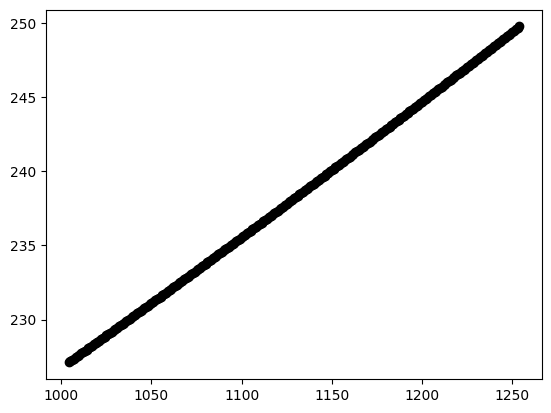

In [22]:
plt.plot(ses_pred_diff, label='Test (Actual)', linewidth=3, color='black', marker='o')

Хольт

In [23]:
model_holt_price = ExponentialSmoothing(train['price'], trend='add', seasonal=None)
fit_holt_price = model_holt_price.fit(optimized=True)
holt_pred = fit_holt_price.forecast(steps=h)
holt_pred.name = 'Holt_price'

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [24]:
model_holt_diff = ExponentialSmoothing(train['diff1'], trend='add', seasonal=None)
fit_holt_diff = model_holt_diff.fit(optimized=True)
holt_diff_fc = fit_holt_diff.forecast(steps=h)
log_forecast_holt = last_log + holt_diff_fc.cumsum()
holt_pred_diff = np.exp(log_forecast_holt)
holt_pred_diff = pd.Series(holt_pred_diff.values, index=test.index,
                           name='Holt_diff(log)->price')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


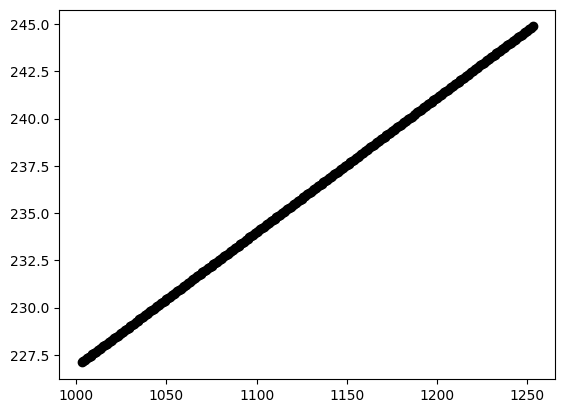

In [25]:
plt.plot(holt_pred, label='Test (Actual)', linewidth=3, color='black', marker='o')

# Хольт-Винтерс

In [26]:
model_hw_add_price = ExponentialSmoothing(train['price'], trend='add',
                                          seasonal='add', seasonal_periods=period)
fit_hw_add_price = model_hw_add_price.fit(optimized=True)
hw_add = fit_hw_add_price.forecast(steps=h)
hw_add.name = 'HW_add_price'


model_hw_mul_price = ExponentialSmoothing(train['price'], trend='mul',
                                          seasonal='mul', seasonal_periods=period)
fit_hw_mul_price = model_hw_mul_price.fit(optimized=True)
hw_mul = fit_hw_mul_price.forecast(steps=h)
hw_mul.name = 'HW_mul_price'

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/stat

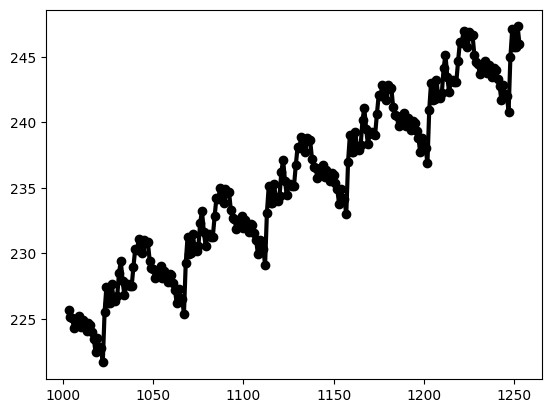

In [27]:
plt.plot(hw_mul, label='Test (Actual)', linewidth=3, color='black', marker='o')


In [28]:
model_hw_add_diff = ExponentialSmoothing(train['diff1'], trend='add',
                                         seasonal='add', seasonal_periods=period)
fit_hw_add_diff = model_hw_add_diff.fit(optimized=True)
hw_add_diff_fc = fit_hw_add_diff.forecast(steps=h)
log_forecast_hw_add = last_log + hw_add_diff_fc.cumsum()
hw_add_pred_diff = np.exp(log_forecast_hw_add)
hw_add_pred_diff = pd.Series(hw_add_pred_diff.values, index=test.index,
                             name='HW_add_diff')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


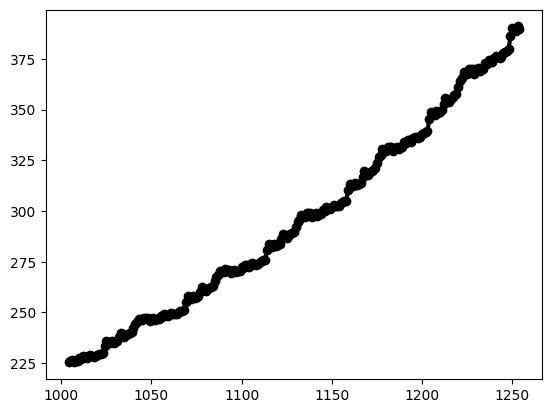

In [29]:
plt.plot(hw_add_pred_diff, label='Test (Actual)', linewidth=3, color='black', marker='o')

# Визуализация всех прогнозов

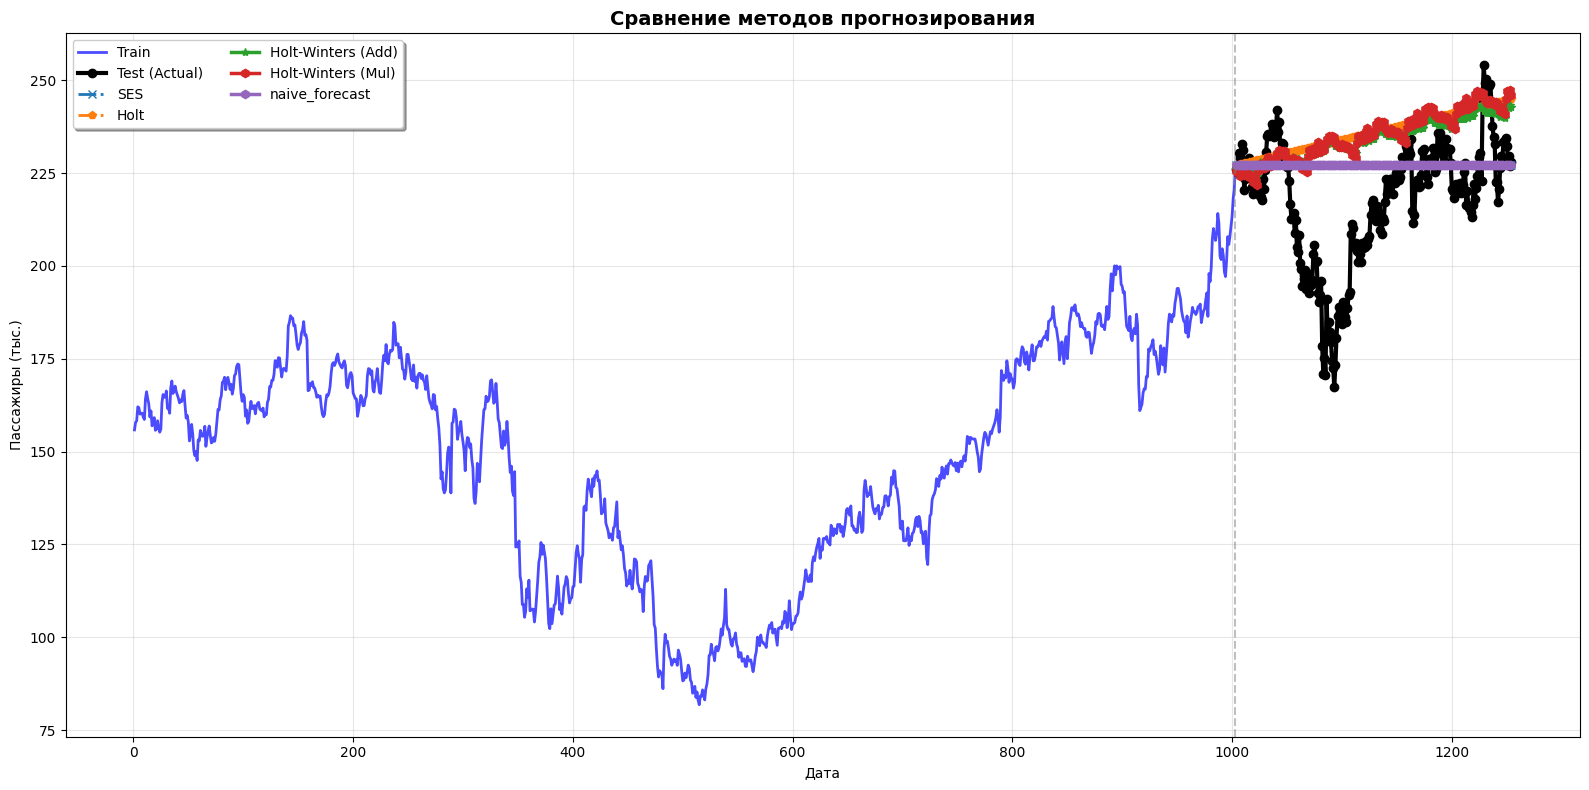

In [30]:
plt.figure(figsize=(16, 8))

plt.plot(train.index, train['price'], label='Train', linewidth=2, color='blue', alpha=0.7)
plt.plot(test.index, test['price'], label='Test (Actual)', linewidth=3, color='black', marker='o')


plt.plot(test.index, ses_pred, label='SES', linewidth=2, linestyle='-.', marker='x')
plt.plot(test.index, holt_pred, label='Holt', linewidth=2, linestyle='-.', marker='p')

plt.plot(test.index, hw_add, label='Holt-Winters (Add)', linewidth=2.5, marker='*')
plt.plot(test.index, hw_mul, label='Holt-Winters (Mul)', linewidth=2.5, marker='h')

plt.plot(test.index, naive_forecast, label='naive_forecast', linewidth=2.5, marker='h')


plt.axvline(train.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title('Сравнение методов прогнозирования', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.legend(loc='upper left', frameon=True, shadow=True, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

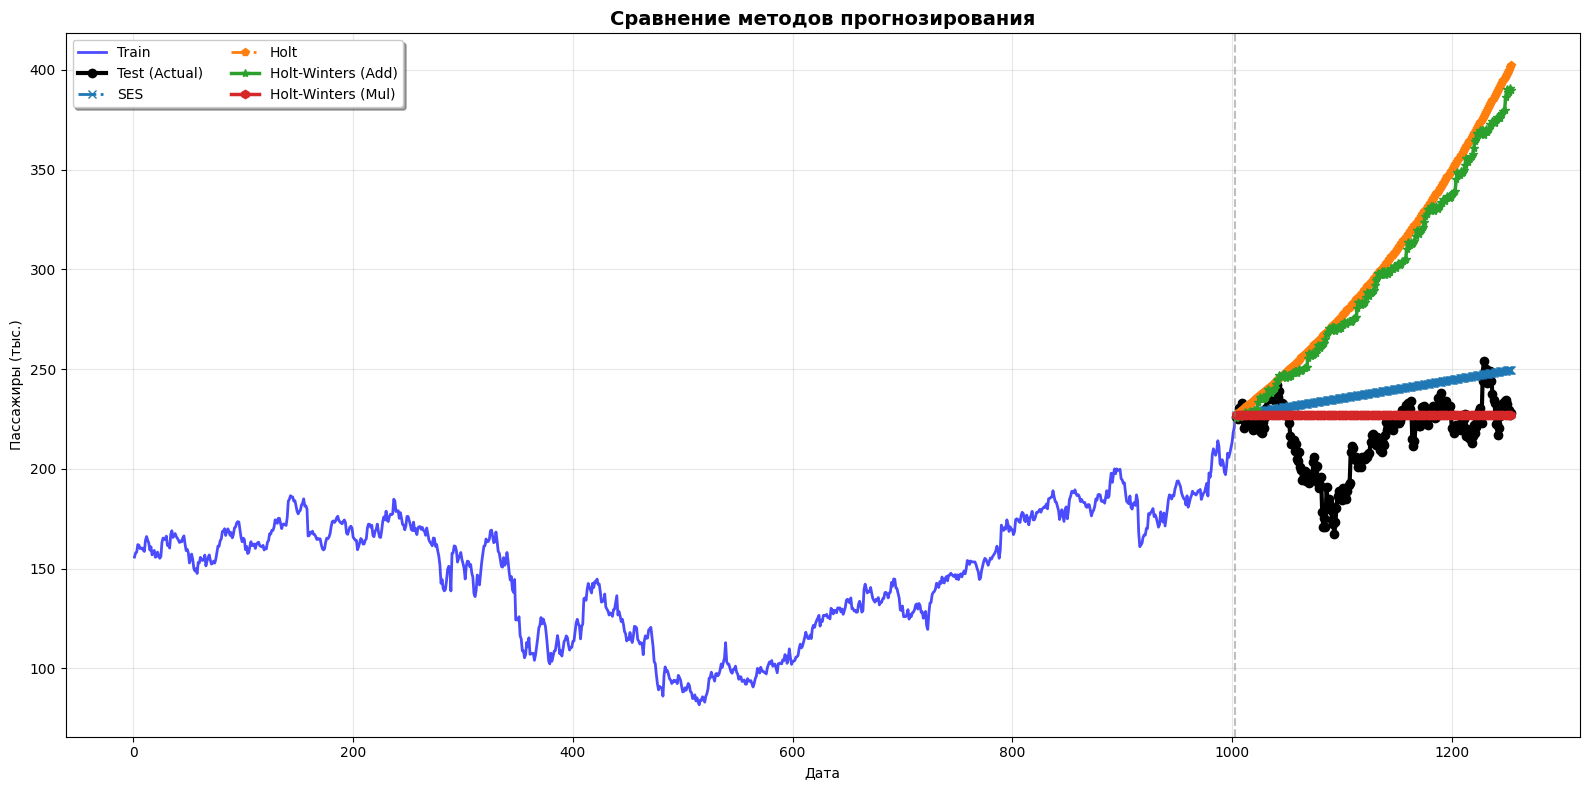

In [31]:
plt.figure(figsize=(16, 8))

plt.plot(train.index, train['price'], label='Train', linewidth=2, color='blue', alpha=0.7)
plt.plot(test.index, test['price'], label='Test (Actual)', linewidth=3, color='black', marker='o')


plt.plot(test.index, ses_pred_diff, label='SES', linewidth=2, linestyle='-.', marker='x')
plt.plot(test.index, holt_pred_diff, label='Holt', linewidth=2, linestyle='-.', marker='p')

plt.plot(test.index, hw_add_pred_diff, label='Holt-Winters (Add)', linewidth=2.5, marker='*')
# plt.plot(test.index, hw_mul, label='Holt-Winters (Mul)', linewidth=2.5, marker='h')

plt.plot(test.index, naive_forecast, label='Holt-Winters (Mul)', linewidth=2.5, marker='h')

plt.axvline(train.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title('Сравнение методов прогнозирования', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.legend(loc='upper left', frameon=True, shadow=True, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 5.2

In [32]:
import numpy as np

def directional_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    real_dir = np.sign(y_true[1:] - y_true[:-1])
    pred_dir = np.sign(y_pred[1:] - y_pred[:-1])

    return (real_dir == pred_dir).mean() * 100

In [33]:
results = []

y_true = test['price']
results.append({
    "model": "Naive_last_value",
    "stationarity": "No",
    "MAE": mae(y_true, naive_forecast),
    "RMSE": rmse(y_true, naive_forecast),
    "MAPE": mape(y_true, naive_forecast)
})

results.append({
    "model": "SES_price",
    "stationarity": "No",
    "MAE": mae(y_true, ses_pred),
    "RMSE": rmse(y_true, ses_pred),
    "MAPE": mape(y_true, ses_pred)
})

results.append({
    "model": "SES_diff",
    "stationarity": "Yes",
    "MAE": mae(y_true, ses_pred_diff),
    "RMSE": rmse(y_true, ses_pred_diff),
    "MAPE": mape(y_true, ses_pred_diff)
})

results.append({
    "model": "Holt_price",
    "stationarity": "No",
    "MAE": mae(y_true, holt_pred),
    "RMSE": rmse(y_true, holt_pred),
    "MAPE": mape(y_true, holt_pred)
})

results.append({
    "model": "Holt_diff",
    "stationarity": "Yes",
    "MAE": mae(y_true, holt_pred_diff),
    "RMSE": rmse(y_true, holt_pred_diff),
    "MAPE": mape(y_true, holt_pred_diff)
})

results.append({
    "model": "HW_mul_price",
    "stationarity": "No",
    "MAE": mae(y_true, hw_mul),
    "RMSE": rmse(y_true, hw_mul),
    "MAPE": mape(y_true, hw_mul)
})

results.append({
    "model": "HW_add_diff",
    "stationarity": "Yes",
    "MAE": mae(y_true, hw_add_pred_diff),
    "RMSE": rmse(y_true, hw_add_pred_diff),
    "MAPE": mape(y_true, hw_add_pred_diff)
})

metrics_df = pd.DataFrame(results).set_index("model")
metrics_df


,stationarity,MAE,RMSE,MAPE
model,,,,
Naive_last_value,No,13.764381,377.069858,0.068412
SES_price,No,13.764381,377.069856,0.068412
SES_diff,Yes,21.625516,688.208026,0.105470
Holt_price,No,19.622554,599.056143,0.096236
Holt_diff,Yes,84.371571,9302.885931,0.390006
HW_mul_price,No,19.085084,575.998994,0.093591
HW_add_diff,Yes,78.585575,8136.139502,0.363618


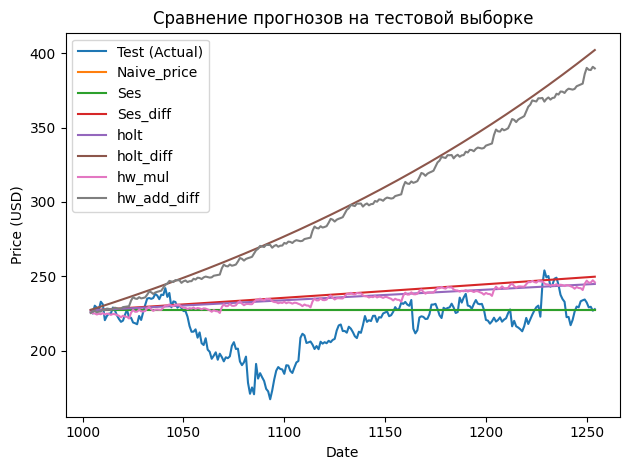

In [34]:
plt.figure()
plt.plot(test.index, y_true, label='Test (Actual)')

plt.plot(test.index, naive_forecast, label='Naive_price')

plt.plot(test.index, ses_pred, label='Ses')
plt.plot(test.index, ses_pred_diff, label='Ses_diff')

plt.plot(test.index, holt_pred, label='holt')
plt.plot(test.index, holt_pred_diff, label='holt_diff')

plt.plot(test.index, hw_mul, label='hw_mul')
plt.plot(test.index, hw_add_pred_diff, label='hw_add_diff')

plt.title('Сравнение прогнозов на тестовой выборке')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

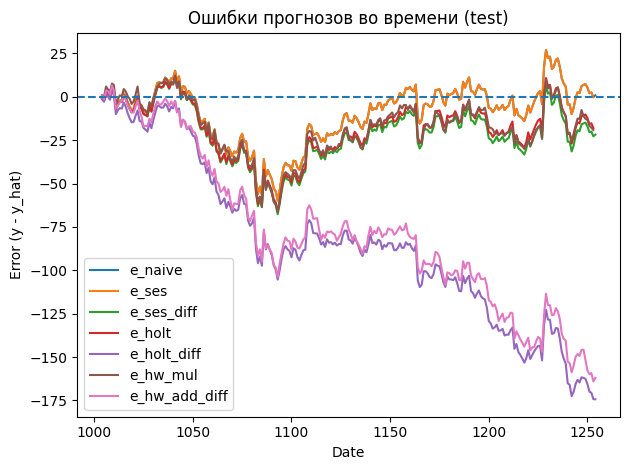

In [35]:
naive_aligned = naive_forecast.reindex(test.index)
ses_pred_aligned = ses_pred.reindex(test.index)
ses_pred_diff_aligned = ses_pred_diff.reindex(test.index)
holt_pred_aligned = holt_pred.reindex(test.index)
holt_pred_diff_aligned = holt_pred_diff.reindex(test.index)
hw_mul_aligned = hw_mul.reindex(test.index)
hw_add_pred_diff_aligned = hw_add_pred_diff.reindex(test.index)


e_naive = y_true - naive_aligned
e_ses = y_true - ses_pred_aligned
e_ses_diff = y_true - ses_pred_diff_aligned
e_holt = y_true - holt_pred_aligned
e_holt_diff = y_true - holt_pred_diff_aligned
e_hw_mul = y_true - hw_mul_aligned
e_hw_add_diff = y_true - hw_add_pred_diff_aligned


plt.figure()
plt.plot(test.index, e_naive, label='e_naive')
plt.plot(test.index, e_ses, label='e_ses')
plt.plot(test.index, e_ses_diff, label='e_ses_diff')
plt.plot(test.index, e_holt, label='e_holt')
plt.plot(test.index, e_holt_diff, label='e_holt_diff')
plt.plot(test.index, e_hw_mul, label='e_hw_mul')
plt.plot(test.index, e_hw_add_diff, label='e_hw_add_diff')
plt.axhline(0, linestyle='--')
plt.title('Ошибки прогнозов во времени (test)')
plt.xlabel('Date')
plt.ylabel('Error (y - y_hat)')
plt.legend()
plt.tight_layout()
plt.show()

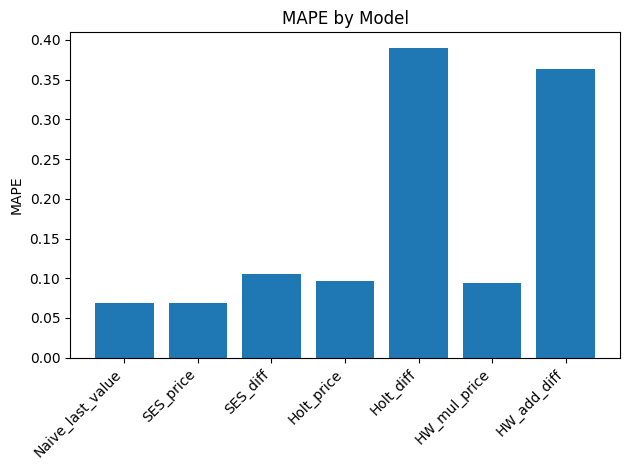

In [36]:
plt.figure()
plt.bar(metrics_df.index, metrics_df["MAPE"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("MAPE")
plt.title("MAPE by Model")
plt.tight_layout()
plt.show()

In [37]:
def diebold_mariano(y_true, y_pred1, y_pred2, h=1, power=2):
    e1 = y_true - y_pred1
    e2 = y_true - y_pred2
    d = np.abs(e1) ** power - np.abs(e2) ** power
    T = len(d)
    mean_d = d.mean()

    lag = max(h - 1, 0)
    gamma0 = np.var(d, ddof=1)
    var_d = gamma0
    for k in range(1, lag + 1):
        cov = np.cov(d[k:], d[:-k], ddof=1)[0, 1]
        var_d += 2 * (1 - k / (lag + 1)) * cov

    DM_stat = mean_d / math.sqrt(var_d / T)

    p_value = 2 * (1 - 0.5 * (1 + math.erf(abs(DM_stat) / math.sqrt(2))))
    return DM_stat, p_value

In [38]:
alpha = 0.05

dm_stat_1, p_val_1 = diebold_mariano(y_true, hw_add, naive_forecast, h=1, power=2)
print('HW_add_price vs Naive_price:')
print(f'  DM statistic = {dm_stat_1:.3f}, p-value = {p_val_1:.4f}')
if p_val_1 < alpha:
    print('  Различия статистически значимы на уровне 5%.')
else:
    print('  Нет статистически значимых различий на уровне 5%.')

print('\n')

dm_stat_2, p_val_2 = diebold_mariano(y_true, hw_add_pred_diff, hw_add, h=1, power=2)
print('HW_add_diff(log)->price vs HW_add_price:')
print(f'  DM statistic = {dm_stat_2:.3f}, p-value = {p_val_2:.4f}')
if p_val_2 < alpha:
    print('  Различия статистически значимы на уровне 5%.')
else:
    print('  Нет статистически значимых различий на уровне 5%.')

HW_add_price vs Naive_price:
  DM statistic = 12.265, p-value = 0.0000
  Различия статистически значимы на уровне 5%.


HW_add_diff(log)->price vs HW_add_price:
  DM statistic = 17.452, p-value = 0.0000
  Различия статистически значимы на уровне 5%.


# 6

### naive_forecast

In [39]:
def metrics_price(y_true: np.ndarray, y_pred: np.ndarray):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true))

    direction_true = np.sign(y_true[1:] - y_true[:-1])
    direction_pred = np.sign(y_pred[1:] - y_true[:-1])
    da = np.mean(direction_true == direction_pred)

    return mae, rmse, mape, da


### SES

In [40]:
ks = [1, 2, 5, 10]
k_alpha = {k: 1.0/k for k in ks}

In [41]:
results = []
timing = []

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
ses_pred_k = {}

for k in ks:
    start = time.perf_counter()

    key = f"ses_pred_{k}"
    ses_pred_k[key] = []

    h = n - split
    full_steps = (h // k) * k
    rem = h - full_steps

    for b in range(h // k):
        i = b * k
        train = df.iloc[:split + i].copy()

        model = ExponentialSmoothing(train['price'], trend=None, seasonal=None)
        fit = model.fit(optimized=True)

        ses_forecast = fit.forecast(steps=k)         
        ses_pred_k[key].extend(ses_forecast.values) 


    if rem > 0:
        train = df.iloc[:split + full_steps].copy()

        model = ExponentialSmoothing(train['price'], trend=None, seasonal=None)
        fit = model.fit(optimized=True)

        ses_forecast = fit.forecast(steps=rem)     
        ses_pred_k[key].extend(ses_forecast.values)

    ses_pred_k[key] = ses_pred_k[key][:len(test)]

    elapsed = time.perf_counter() - start
    timing.append({
        "model": key,
        "k": k,
        "time_sec": elapsed
    })  

In [44]:
for ses in ses_pred_k:
    yt = test['price']
    yp = ses_pred_k[ses]

    mae, rmse, mape, da = metrics_price(yt, yp)
    results.append({
        "model": ses,
        "stationarity": "No",
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "DA": da
    })

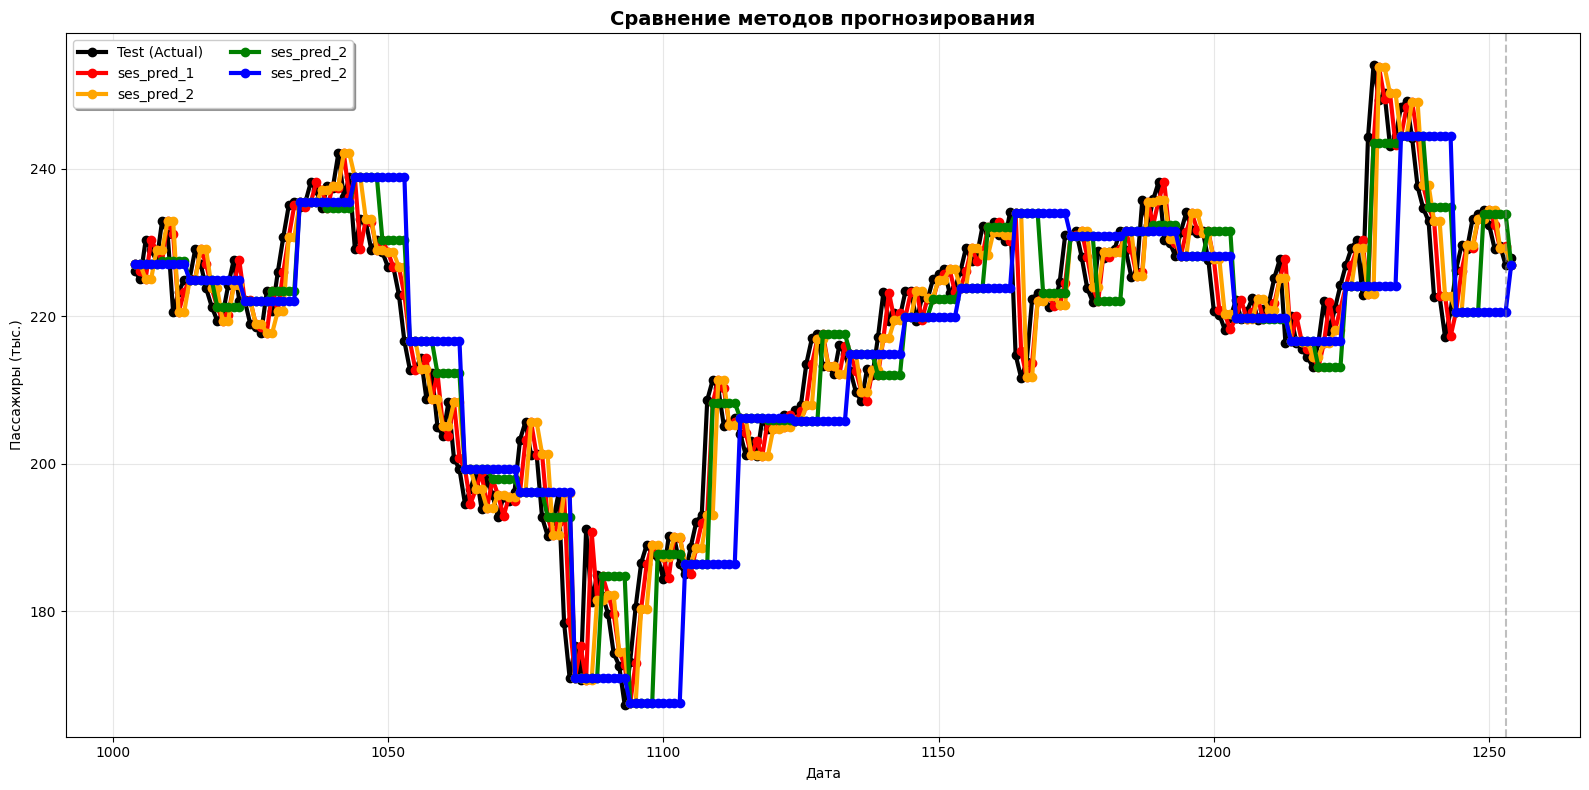

In [45]:
plt.figure(figsize=(16, 8))

plt.plot(test.index, test['price'], label='Test (Actual)', linewidth=3, color='black', marker='o')
plt.plot(test.index, ses_pred_k['ses_pred_1'], label='ses_pred_1', linewidth=3, color='red', marker='o')
plt.plot(test.index, ses_pred_k['ses_pred_2'], label='ses_pred_2', linewidth=3, color='orange', marker='o')
plt.plot(test.index, ses_pred_k['ses_pred_5'], label='ses_pred_2', linewidth=3, color='green', marker='o')
plt.plot(test.index, ses_pred_k['ses_pred_10'], label='ses_pred_2', linewidth=3, color='blue', marker='o')


plt.axvline(train.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title('Сравнение методов прогнозирования', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.legend(loc='upper left', frameon=True, shadow=True, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### SES_diff

In [46]:
ses_pred_diff_k = {}

for k in ks:
    start = time.perf_counter()

    key = f"ses_pred_diff_{k}"
    ses_pred_diff_k[key] = []

    h = n - split
    full_steps = (h // k) * k
    rem = h - full_steps

    for b in range(h // k):
        i = b * k
        train = df.iloc[:split + i].copy()

        model_ses_diff = ExponentialSmoothing(train["diff1"], trend=None, seasonal=None)
        fit_ses_diff = model_ses_diff.fit(optimized=True)

        ses_diff_fc = fit_ses_diff.forecast(steps=k)

        last_log = train["log"].iloc[-1]
        log_forecast_ses = last_log + ses_diff_fc.cumsum()
        ses_pred_diff = np.exp(log_forecast_ses)

        ses_pred_diff_k[key].extend(np.asarray(ses_pred_diff))

    if rem > 0:
        train = df.iloc[:split + full_steps].copy()

        model_ses_diff = ExponentialSmoothing(train["diff1"], trend=None, seasonal=None)
        fit_ses_diff = model_ses_diff.fit(optimized=True)

        ses_diff_fc = fit_ses_diff.forecast(steps=rem)

        last_log = train["log"].iloc[-1]
        log_forecast_ses = last_log + ses_diff_fc.cumsum()
        ses_pred_diff = np.exp(log_forecast_ses)

        ses_pred_diff_k[key].extend(np.asarray(ses_pred_diff))

    ses_pred_diff_k[key] = ses_pred_diff_k[key][:len(test)]

    elapsed = time.perf_counter() - start
    timing.append({
        "model": key,
        "k": k,
        "time_sec": elapsed
    })

In [47]:
for ses in ses_pred_diff_k:
    yt = test['price']
    yp = ses_pred_diff_k[ses]

    mae, rmse, mape, da = metrics_price(yt, yp)
    results.append({
        "model": ses,
        "stationarity": "Yes",
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "DA": da
    })

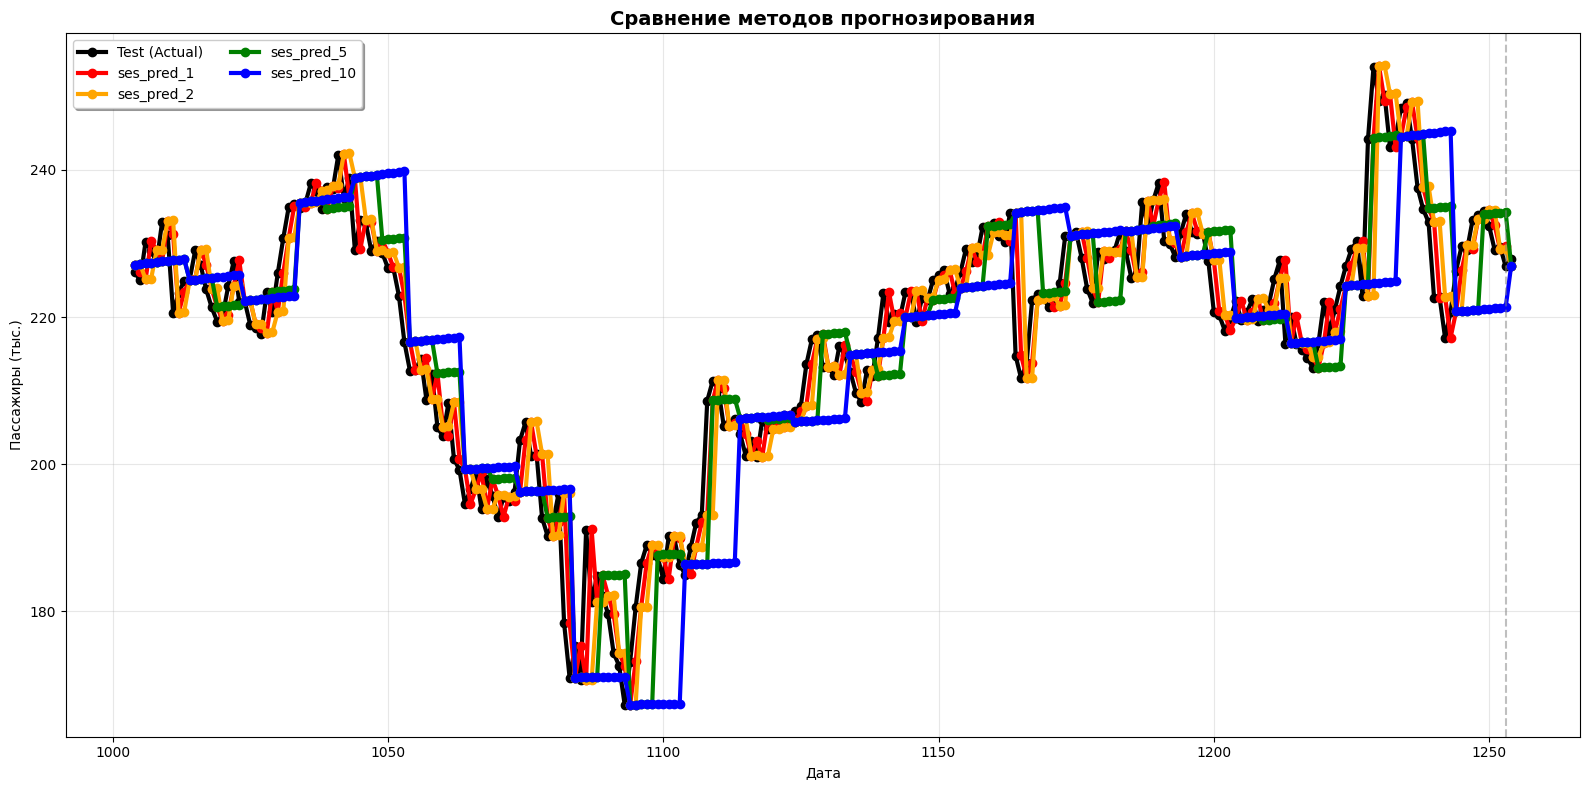

In [48]:
plt.figure(figsize=(16, 8))

plt.plot(test.index, test['price'], label='Test (Actual)', linewidth=3, color='black', marker='o')
plt.plot(test.index, ses_pred_diff_k['ses_pred_diff_1'], label='ses_pred_1', linewidth=3, color='red', marker='o')
plt.plot(test.index, ses_pred_diff_k['ses_pred_diff_2'], label='ses_pred_2', linewidth=3, color='orange', marker='o')
plt.plot(test.index, ses_pred_diff_k['ses_pred_diff_5'], label='ses_pred_5', linewidth=3, color='green', marker='o')
plt.plot(test.index, ses_pred_diff_k['ses_pred_diff_10'], label='ses_pred_10', linewidth=3, color='blue', marker='o')


plt.axvline(train.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title('Сравнение методов прогнозирования', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.legend(loc='upper left', frameon=True, shadow=True, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Holt

In [49]:
holt_pred_k = {}

for k in ks:
    start = time.perf_counter()

    key = f"holt_pred_{k}"
    holt_pred_k[key] = []

    h = n - split
    full_steps = (h // k) * k
    rem = h - full_steps

    for b in range(h // k):
        i = b * k
        train = df.iloc[:split + i].copy()

        model_holt_price = ExponentialSmoothing(
            train['price'],
            trend='add',
            seasonal=None
        )
        fit_holt_price = model_holt_price.fit(optimized=True)

        holt_forecast = fit_holt_price.forecast(steps=k)
        holt_pred_k[key].extend(holt_forecast.values)

    if rem > 0:
        train = df.iloc[:split + full_steps].copy()

        model_holt_price = ExponentialSmoothing(
            train['price'],
            trend='add',
            seasonal=None
        )
        fit_holt_price = model_holt_price.fit(optimized=True)

        holt_forecast = fit_holt_price.forecast(steps=rem)
        holt_pred_k[key].extend(holt_forecast.values)

    holt_pred_k[key] = holt_pred_k[key][:len(test)]

    elapsed = time.perf_counter() - start
    timing.append({
        "model": key,
        "k": k,
        "time_sec": elapsed
    }) 

In [50]:
for holt in holt_pred_k:
    yt = test['price']
    yp = holt_pred_k[holt]

    mae, rmse, mape, da = metrics_price(yt, yp)
    results.append({
        "model": holt,
        "stationarity": "No",
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "DA": da
    })

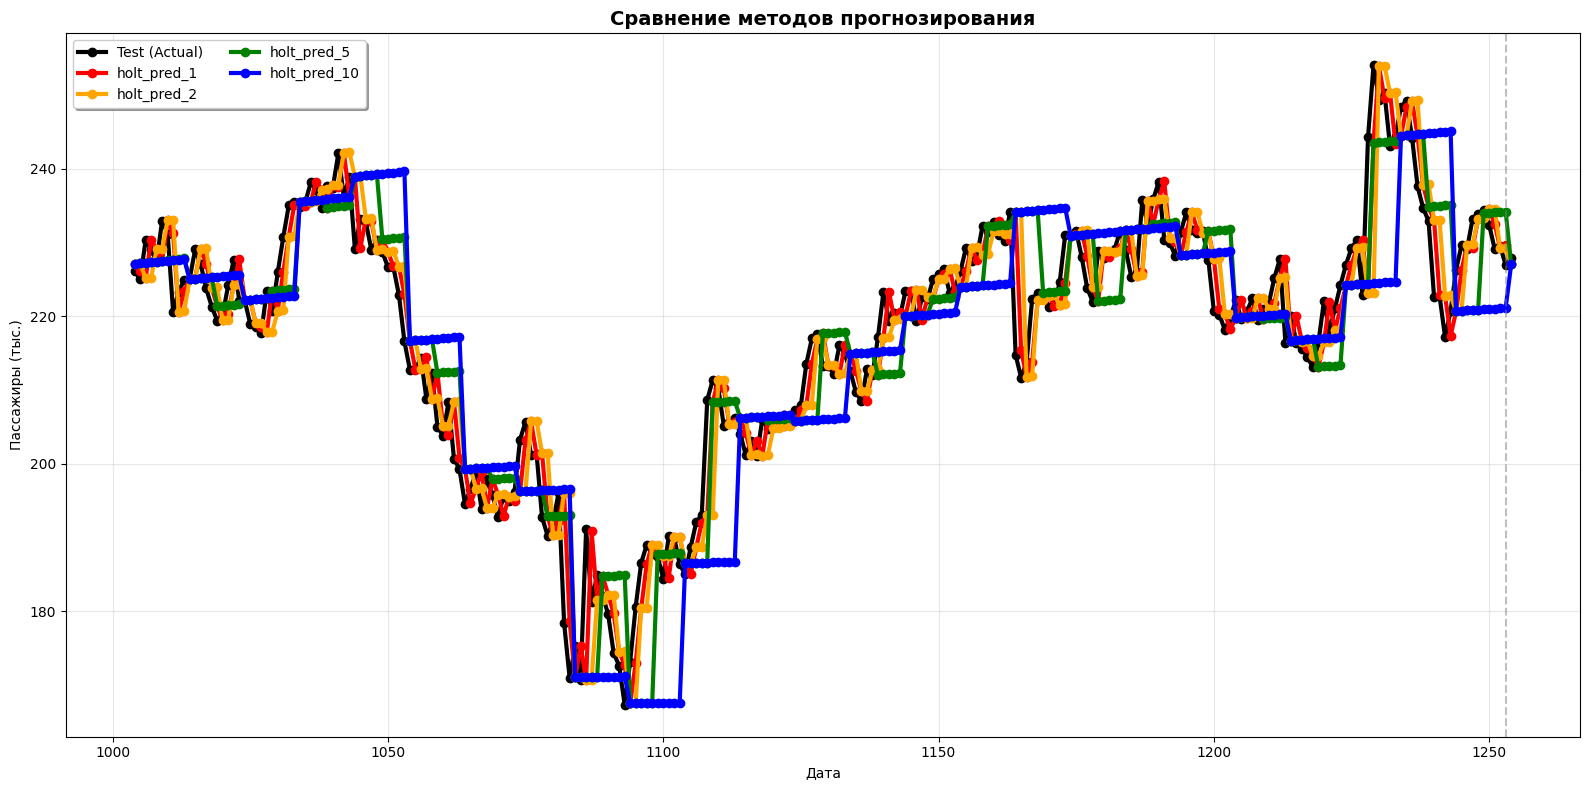

In [51]:
plt.figure(figsize=(16, 8))

plt.plot(test.index, test['price'], label='Test (Actual)', linewidth=3, color='black', marker='o')
plt.plot(test.index, holt_pred_k['holt_pred_1'], label='holt_pred_1', linewidth=3, color='red', marker='o')
plt.plot(test.index, holt_pred_k['holt_pred_2'], label='holt_pred_2', linewidth=3, color='orange', marker='o')
plt.plot(test.index, holt_pred_k['holt_pred_5'], label='holt_pred_5', linewidth=3, color='green', marker='o')
plt.plot(test.index, holt_pred_k['holt_pred_10'], label='holt_pred_10', linewidth=3, color='blue', marker='o')


plt.axvline(train.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title('Сравнение методов прогнозирования', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.legend(loc='upper left', frameon=True, shadow=True, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### holt_diff

In [52]:
holt_diff_pred_k = {}

for k in ks:
    start = time.perf_counter()

    key = f"holt_diff_pred_{k}"
    holt_diff_pred_k[key] = []

    h = n - split
    full_steps = (h // k) * k
    rem = h - full_steps

    for b in range(h // k):
        i = b * k
        train = df.iloc[:split + i].copy()

        train_diff = train['diff1'].dropna()
        last_log = train['log'].iloc[-1]

        model_holt_diff = ExponentialSmoothing(
            train_diff,
            trend='add',
            seasonal=None
        )
        fit_holt_diff = model_holt_diff.fit(optimized=True)

        holt_diff_fc = fit_holt_diff.forecast(steps=k)

        log_forecast = last_log + holt_diff_fc.cumsum()
        price_forecast = np.exp(log_forecast)

        holt_diff_pred_k[key].extend(price_forecast.values)

    if rem > 0:
        train = df.iloc[:split + full_steps].copy()

        train_diff = train['diff1'].dropna()
        last_log = train['log'].iloc[-1]

        model_holt_diff = ExponentialSmoothing(
            train_diff,
            trend='add',
            seasonal=None
        )
        fit_holt_diff = model_holt_diff.fit(optimized=True)

        holt_diff_fc = fit_holt_diff.forecast(steps=rem)

        log_forecast = last_log + holt_diff_fc.cumsum()
        price_forecast = np.exp(log_forecast)

        holt_diff_pred_k[key].extend(price_forecast.values)

    holt_diff_pred_k[key] = holt_diff_pred_k[key][:len(test)]

    elapsed = time.perf_counter() - start
    timing.append({
        "model": key,
        "k": k,
        "time_sec": elapsed
    })


In [53]:
for holt in holt_diff_pred_k:
    yt = test['price']
    yp = holt_diff_pred_k[holt]

    mae, rmse, mape, da = metrics_price(yt, yp)
    results.append({
        "model": holt,
        "stationarity": "Yes",
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "DA": da
    })

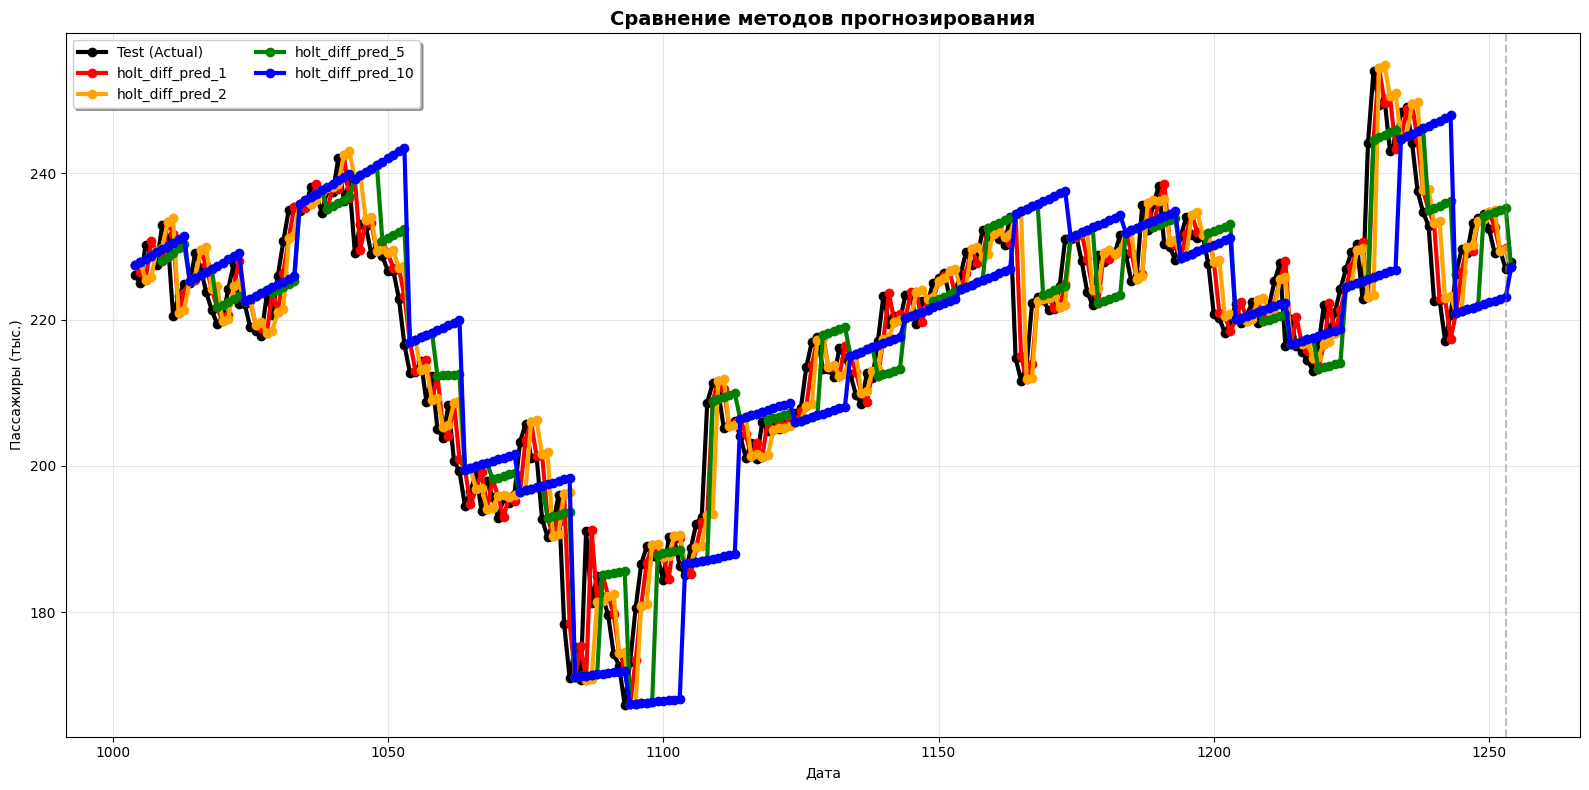

In [54]:
plt.figure(figsize=(16, 8))

plt.plot(test.index, test['price'], label='Test (Actual)', linewidth=3, color='black', marker='o')
plt.plot(test.index, holt_diff_pred_k['holt_diff_pred_1'], label='holt_diff_pred_1', linewidth=3, color='red', marker='o')
plt.plot(test.index, holt_diff_pred_k['holt_diff_pred_2'], label='holt_diff_pred_2', linewidth=3, color='orange', marker='o')
plt.plot(test.index, holt_diff_pred_k['holt_diff_pred_5'], label='holt_diff_pred_5', linewidth=3, color='green', marker='o')
plt.plot(test.index, holt_diff_pred_k['holt_diff_pred_10'], label='holt_diff_pred_10', linewidth=3, color='blue', marker='o')


plt.axvline(train.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title('Сравнение методов прогнозирования', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.legend(loc='upper left', frameon=True, shadow=True, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### hw_add

In [55]:
hw_add_pred_k = {}

for k in ks:
    start = time.perf_counter()

    key = f"hw_add_pred_{k}"
    hw_add_pred_k[key] = []

    h = n - split
    full_steps = (h // k) * k
    rem = h - full_steps

    for b in range(h // k):
        i = b * k
        train = df.iloc[:split + i].copy()

        model_hw_add_price = ExponentialSmoothing(
            train['price'],
            trend='add',
            seasonal='add',
            seasonal_periods=period
        )
        fit_hw_add_price = model_hw_add_price.fit(optimized=True)

        hw_add_fc = fit_hw_add_price.forecast(steps=k)
        hw_add_pred_k[key].extend(hw_add_fc.values)

    if rem > 0:
        train = df.iloc[:split + full_steps].copy()

        model_hw_add_price = ExponentialSmoothing(
            train['price'],
            trend='add',
            seasonal='add',
            seasonal_periods=period
        )
        fit_hw_add_price = model_hw_add_price.fit(optimized=True)

        hw_add_fc = fit_hw_add_price.forecast(steps=rem)
        hw_add_pred_k[key].extend(hw_add_fc.values)

    hw_add_pred_k[key] = hw_add_pred_k[key][:len(test)]


    elapsed = time.perf_counter() - start
    timing.append({
        "model": key,
        "k": k,
        "time_sec": elapsed
    })

In [56]:
for holt in hw_add_pred_k:
    yt = test['price']
    yp = hw_add_pred_k[holt]

    mae, rmse, mape, da = metrics_price(yt, yp)
    results.append({
        "model": holt,
        "stationarity": "No",
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "DA": da
    })

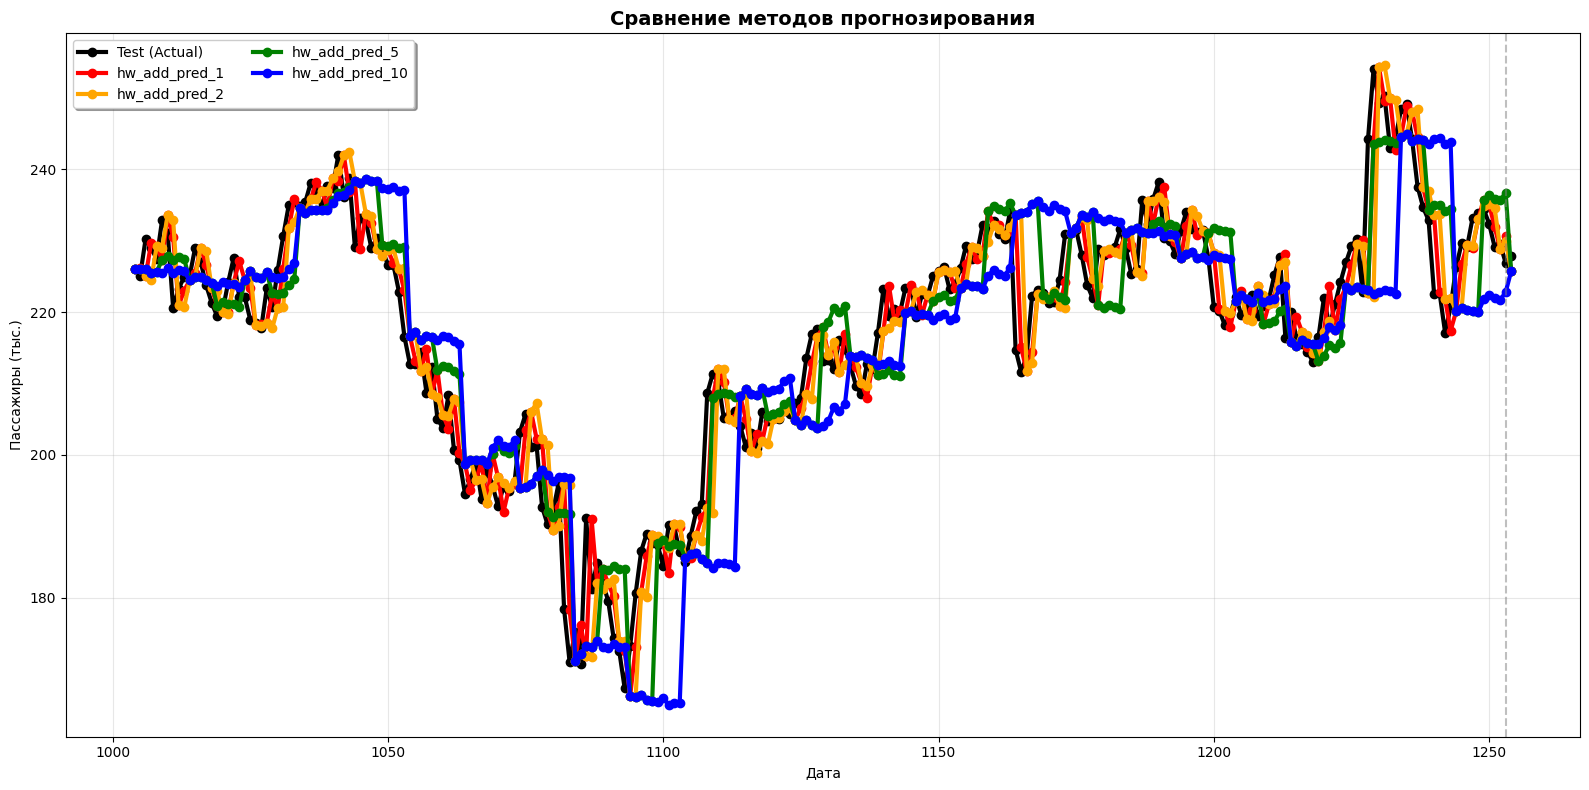

In [57]:
plt.figure(figsize=(16, 8))

plt.plot(test.index, test['price'], label='Test (Actual)', linewidth=3, color='black', marker='o')
plt.plot(test.index, hw_add_pred_k['hw_add_pred_1'], label='hw_add_pred_1', linewidth=3, color='red', marker='o')
plt.plot(test.index, hw_add_pred_k['hw_add_pred_2'], label='hw_add_pred_2', linewidth=3, color='orange', marker='o')
plt.plot(test.index, hw_add_pred_k['hw_add_pred_5'], label='hw_add_pred_5', linewidth=3, color='green', marker='o')
plt.plot(test.index, hw_add_pred_k['hw_add_pred_10'], label='hw_add_pred_10', linewidth=3, color='blue', marker='o')


plt.axvline(train.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title('Сравнение методов прогнозирования', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.legend(loc='upper left', frameon=True, shadow=True, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [58]:
hw_add_diff_pred_k = {}

for k in ks:
    start = time.perf_counter()

    key = f"hw_add_diff_pred_{k}"
    hw_add_diff_pred_k[key] = []

    h = n - split
    full_steps = (h // k) * k
    rem = h - full_steps

    for b in range(h // k):
        i = b * k
        train = df.iloc[:split + i].copy()

        train_diff = train['diff1'].dropna()
        last_log = train['log'].iloc[-1]

        if len(train_diff) < 2 * period:
            hw_add_diff_pred_k[key].extend([np.nan] * k)
            continue

        model_hw_add_diff = ExponentialSmoothing(
            train_diff,
            trend='add',
            seasonal='add',
            seasonal_periods=period
        )
        fit_hw_add_diff = model_hw_add_diff.fit(optimized=True)

        hw_add_diff_fc = fit_hw_add_diff.forecast(steps=k)

        log_forecast_hw_add = last_log + hw_add_diff_fc.cumsum()
        price_forecast = np.exp(log_forecast_hw_add)

        hw_add_diff_pred_k[key].extend(price_forecast.values)

    if rem > 0:
        train = df.iloc[:split + full_steps].copy()

        train_diff = train['diff1'].dropna()
        last_log = train['log'].iloc[-1]

        if len(train_diff) < 2 * period:
            hw_add_diff_pred_k[key].extend([np.nan] * rem)
        else:
            model_hw_add_diff = ExponentialSmoothing(
                train_diff,
                trend='add',
                seasonal='add',
                seasonal_periods=period
            )
            fit_hw_add_diff = model_hw_add_diff.fit(optimized=True)

            hw_add_diff_fc = fit_hw_add_diff.forecast(steps=rem)

            log_forecast_hw_add = last_log + hw_add_diff_fc.cumsum()
            price_forecast = np.exp(log_forecast_hw_add)

            hw_add_diff_pred_k[key].extend(price_forecast.values)

    hw_add_diff_pred_k[key] = hw_add_diff_pred_k[key][:len(test)]

    elapsed = time.perf_counter() - start
    timing.append({
        "model": key,
        "k": k,
        "time_sec": elapsed
    })


In [59]:
for holt in hw_add_diff_pred_k:
    yt = test['price']
    yp = hw_add_diff_pred_k[holt]

    mae, rmse, mape, da = metrics_price(yt, yp)
    results.append({
        "model": holt,
        "stationarity": "Yes",
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "DA": da
    })

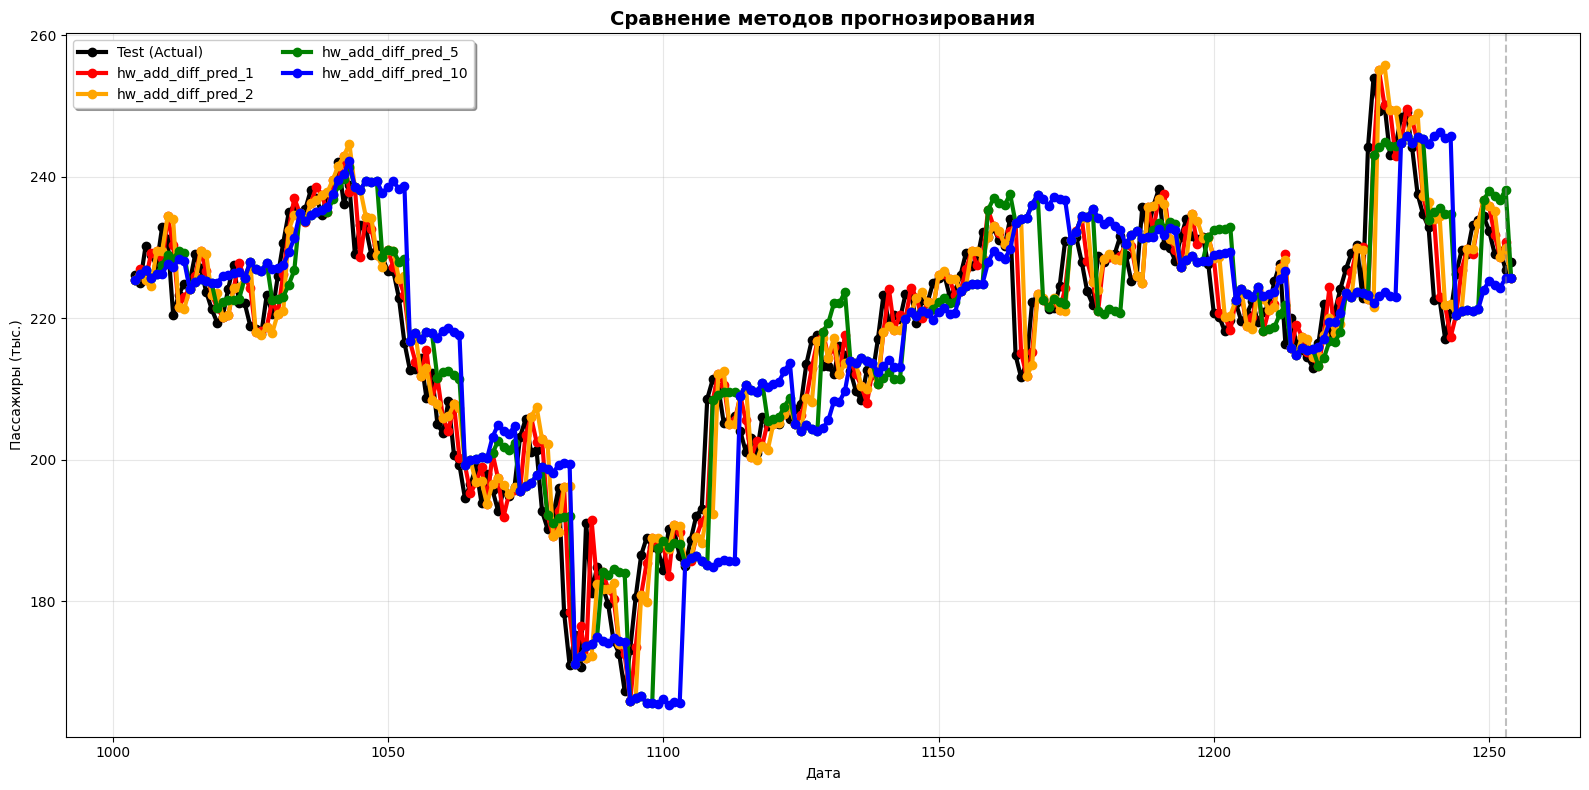

In [60]:
plt.figure(figsize=(16, 8))

plt.plot(test.index, test['price'], label='Test (Actual)', linewidth=3, color='black', marker='o')
plt.plot(test.index, hw_add_diff_pred_k['hw_add_diff_pred_1'], label='hw_add_diff_pred_1', linewidth=3, color='red', marker='o')
plt.plot(test.index, hw_add_diff_pred_k['hw_add_diff_pred_2'], label='hw_add_diff_pred_2', linewidth=3, color='orange', marker='o')
plt.plot(test.index, hw_add_diff_pred_k['hw_add_diff_pred_5'], label='hw_add_diff_pred_5', linewidth=3, color='green', marker='o')
plt.plot(test.index, hw_add_diff_pred_k['hw_add_diff_pred_10'], label='hw_add_diff_pred_10', linewidth=3, color='blue', marker='o')


plt.axvline(train.index[-1], color='gray', linestyle='--', alpha=0.5)
plt.title('Сравнение методов прогнозирования', fontsize=14, fontweight='bold')
plt.xlabel('Дата')
plt.ylabel('Пассажиры (тыс.)')
plt.legend(loc='upper left', frameon=True, shadow=True, ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [61]:
metrics = pd.DataFrame(results)
metrics

,model,stationarity,MAE,RMSE,MAPE,DA
0,ses_pred_1,No,3.260935,4.572403,0.015262,0.532
1,ses_pred_2,No,4.021515,5.927800,0.018807,0.532
2,ses_pred_5,No,5.325290,7.193049,0.025013,0.512
3,ses_pred_10,No,7.126925,9.717940,0.033297,0.504
4,ses_pred_diff_1,Yes,3.256274,4.571093,0.015244,0.516
5,ses_pred_diff_2,Yes,4.030230,5.945746,0.018850,0.524
6,ses_pred_diff_5,Yes,5.345057,7.220578,0.025134,0.504
7,ses_pred_diff_10,Yes,7.151866,9.760868,0.033450,0.528
8,holt_pred_1,No,3.261542,4.574749,0.015268,0.488
9,holt_pred_2,No,4.026636,5.932823,0.018833,0.504


In [62]:
timing = pd.DataFrame(timing)
timing

,model,k,time_sec
0,ses_pred_1,1,0.506516
1,ses_pred_2,2,0.249359
2,ses_pred_5,5,0.104065
3,ses_pred_10,10,0.052986
4,ses_pred_diff_1,1,0.596908
5,ses_pred_diff_2,2,0.296695
6,ses_pred_diff_5,5,0.119150
7,ses_pred_diff_10,10,0.093101
8,holt_pred_1,1,4.986842
9,holt_pred_2,2,2.487003


In [63]:
metrics_timing = metrics.copy()
metrics_timing["time_sec"] = timing["time_sec"].values
metrics_timing["k"] = timing["k"].values

In [64]:
metrics_timing

,model,stationarity,MAE,RMSE,MAPE,DA,time_sec,k
0,ses_pred_1,No,3.260935,4.572403,0.015262,0.532,0.506516,1
1,ses_pred_2,No,4.021515,5.927800,0.018807,0.532,0.249359,2
2,ses_pred_5,No,5.325290,7.193049,0.025013,0.512,0.104065,5
3,ses_pred_10,No,7.126925,9.717940,0.033297,0.504,0.052986,10
4,ses_pred_diff_1,Yes,3.256274,4.571093,0.015244,0.516,0.596908,1
5,ses_pred_diff_2,Yes,4.030230,5.945746,0.018850,0.524,0.296695,2
6,ses_pred_diff_5,Yes,5.345057,7.220578,0.025134,0.504,0.119150,5
7,ses_pred_diff_10,Yes,7.151866,9.760868,0.033450,0.528,0.093101,10
8,holt_pred_1,No,3.261542,4.574749,0.015268,0.488,4.986842,1
9,holt_pred_2,No,4.026636,5.932823,0.018833,0.504,2.487003,2


In [75]:
models = [
    "ses_pred",
    "ses_pred_diff",
    "holt_pred",
    "holt_diff_pred",
    "hw_add_pred",
    "hw_add_diff_pred",
]

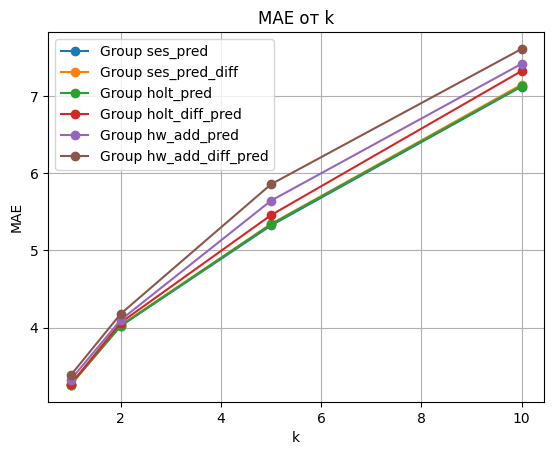

In [76]:
df = metrics_timing.dropna(subset=["k", "MAE"]).reset_index(drop=True)

df["group_id"] = df.index // 4

plt.figure()

for gid, g in df.groupby("group_id"):
    plt.plot(
        g["k"],
        g["MAE"],
        marker="o",
        label=f"{models[gid]}"
    )

plt.xlabel("k")
plt.ylabel("MAE")
plt.title("MAE от k")
plt.grid(True)
plt.legend()
plt.show()

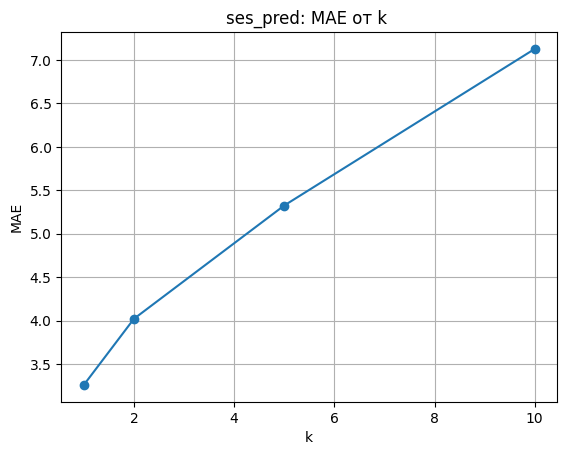

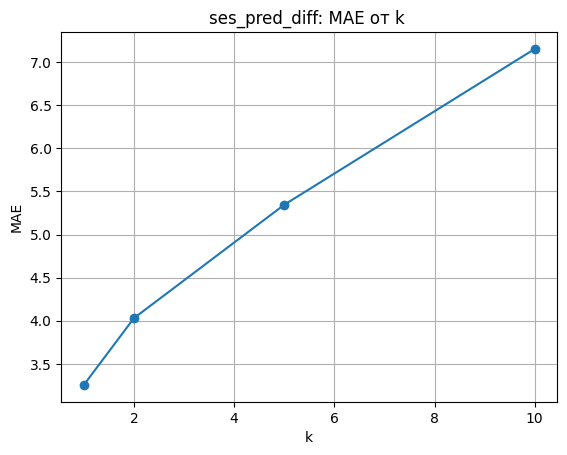

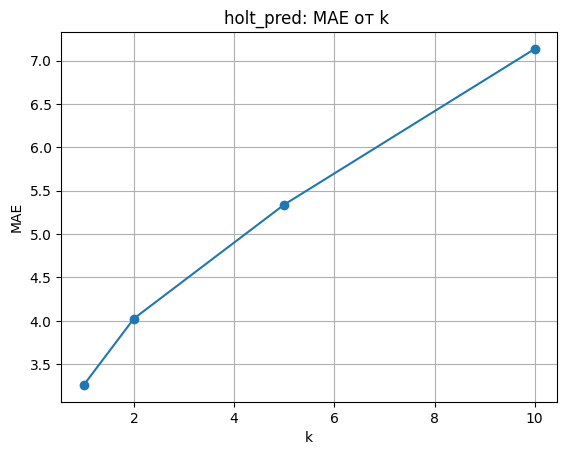

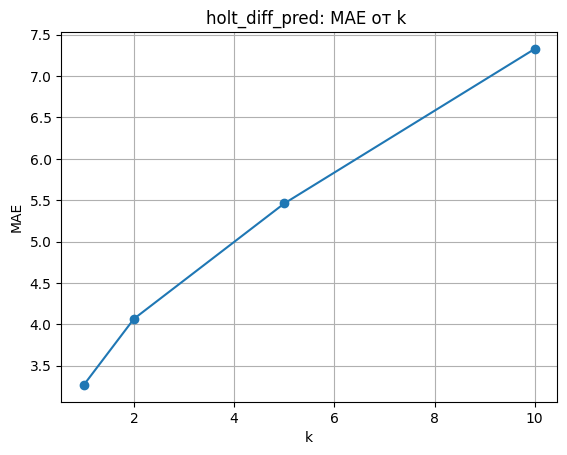

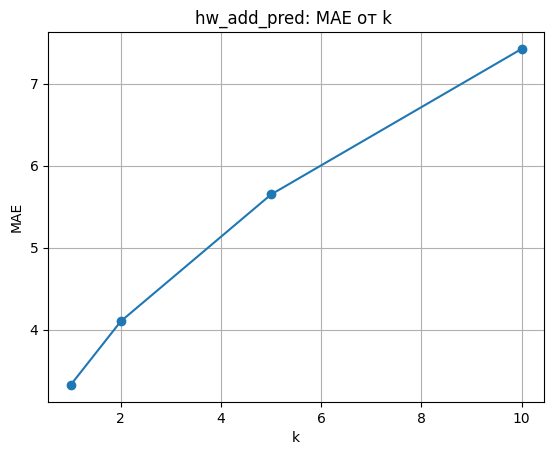

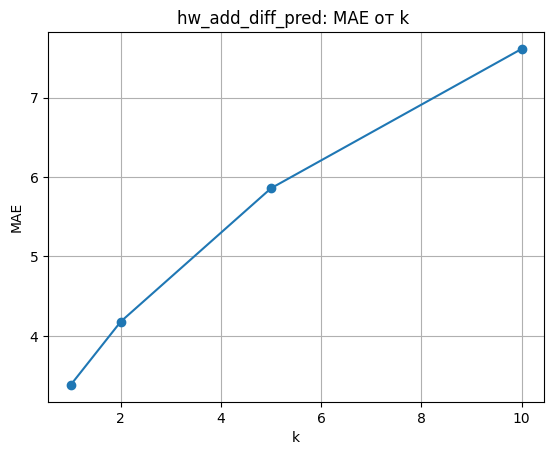

Готово.
Всего строк: 24
Всего групп по 4 строки: 6


In [77]:
for gid, g in df.groupby("group_id"):
    plt.figure()
    plt.plot(g["k"], g["MAE"], marker="o")
    plt.xlabel("k")
    plt.ylabel("MAE")
    plt.title(f"{models[gid]}: MAE от k ")
    plt.grid(True)
    plt.show()


print("Готово.")
print(f"Всего строк: {len(df)}")
print(f"Всего групп по 4 строки: {df['group_id'].nunique()}")
